# Plot snakemake benchmarks (compute resource usage)

Snakemake has a `benchmark` directive that outputs a TSV file per run of the rule that reports comput resource usage.
The table below outlines what values are reported.
Some of the values aren't reported, I think because I ran this locally on a mac?

| colname |	type (unit)  |	description |
|---------|--------------|--------------|
| s       |float (seconds) |	Running time in seconds |
| h:m:s   |string (-) 	| Running time in hour, minutes, seconds format |
| max_rss |float (MB) 	| Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used.|
| max_vms |float (MB) |	Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process |
| max_uss |float (MB) | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now. |
| max_pss |float (MB) |	“Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only) |
| io_in|float (MB) | the number of MB read (cumulative). |
| io_out|float (MB) | the number of MB written (cumulative). |
| mean_load|float (-)| CPU usage over time, divided by the total running time (first row) |
| cpu_time|float (-) | CPU time summed for user and system |

## set up notebook

In [23]:
library(purrr)
library(readr)
library(dplyr, warn.conflicts = F)
library(tidyr)
library(ggplot2)

In [2]:
setwd("..")

In [17]:
# adjust plot size rendered inline
options(repr.plot.width = 6, repr.plot.height = 3.5, repr.plot.res = 300)

## read in benchmarking files

In [6]:
benchmarks <- Sys.glob("benchmarks/*/*tsv") %>%
  set_names() %>%
  map_dfr(read_tsv, col_types = "dtddddddddd", .id = "filename")

In [7]:
benchmarks <- benchmarks %>%
  mutate(filename = gsub("benchmarks\\/", "", filename)) %>%
  separate(filename, into = c("process", "genus"), sep = "\\/") %>%
  mutate(genus = gsub('.tsv', '', genus))

In [21]:
head(benchmarks)

process,genus,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<chr>,<chr>,<dbl>,<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
accessions_to_genus,Agrocybe,19.6609,00:00:19,0,0,0,0,0,0,0.53,0
accessions_to_genus,Amanita,34.5869,00:00:34,0,0,0,0,0,0,0.33,0
accessions_to_genus,Ampulex,33.6939,00:00:33,0,0,0,0,0,0,0.30,0
accessions_to_genus,Bothrops,33.6942,00:00:33,0,0,0,0,0,0,0.30,0
accessions_to_genus,Claviceps,10.4737,00:00:10,0,0,0,0,0,0,0.59,0
accessions_to_genus,Cordyceps,34.5995,00:00:34,0,0,0,0,0,0,0.32,0


## plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


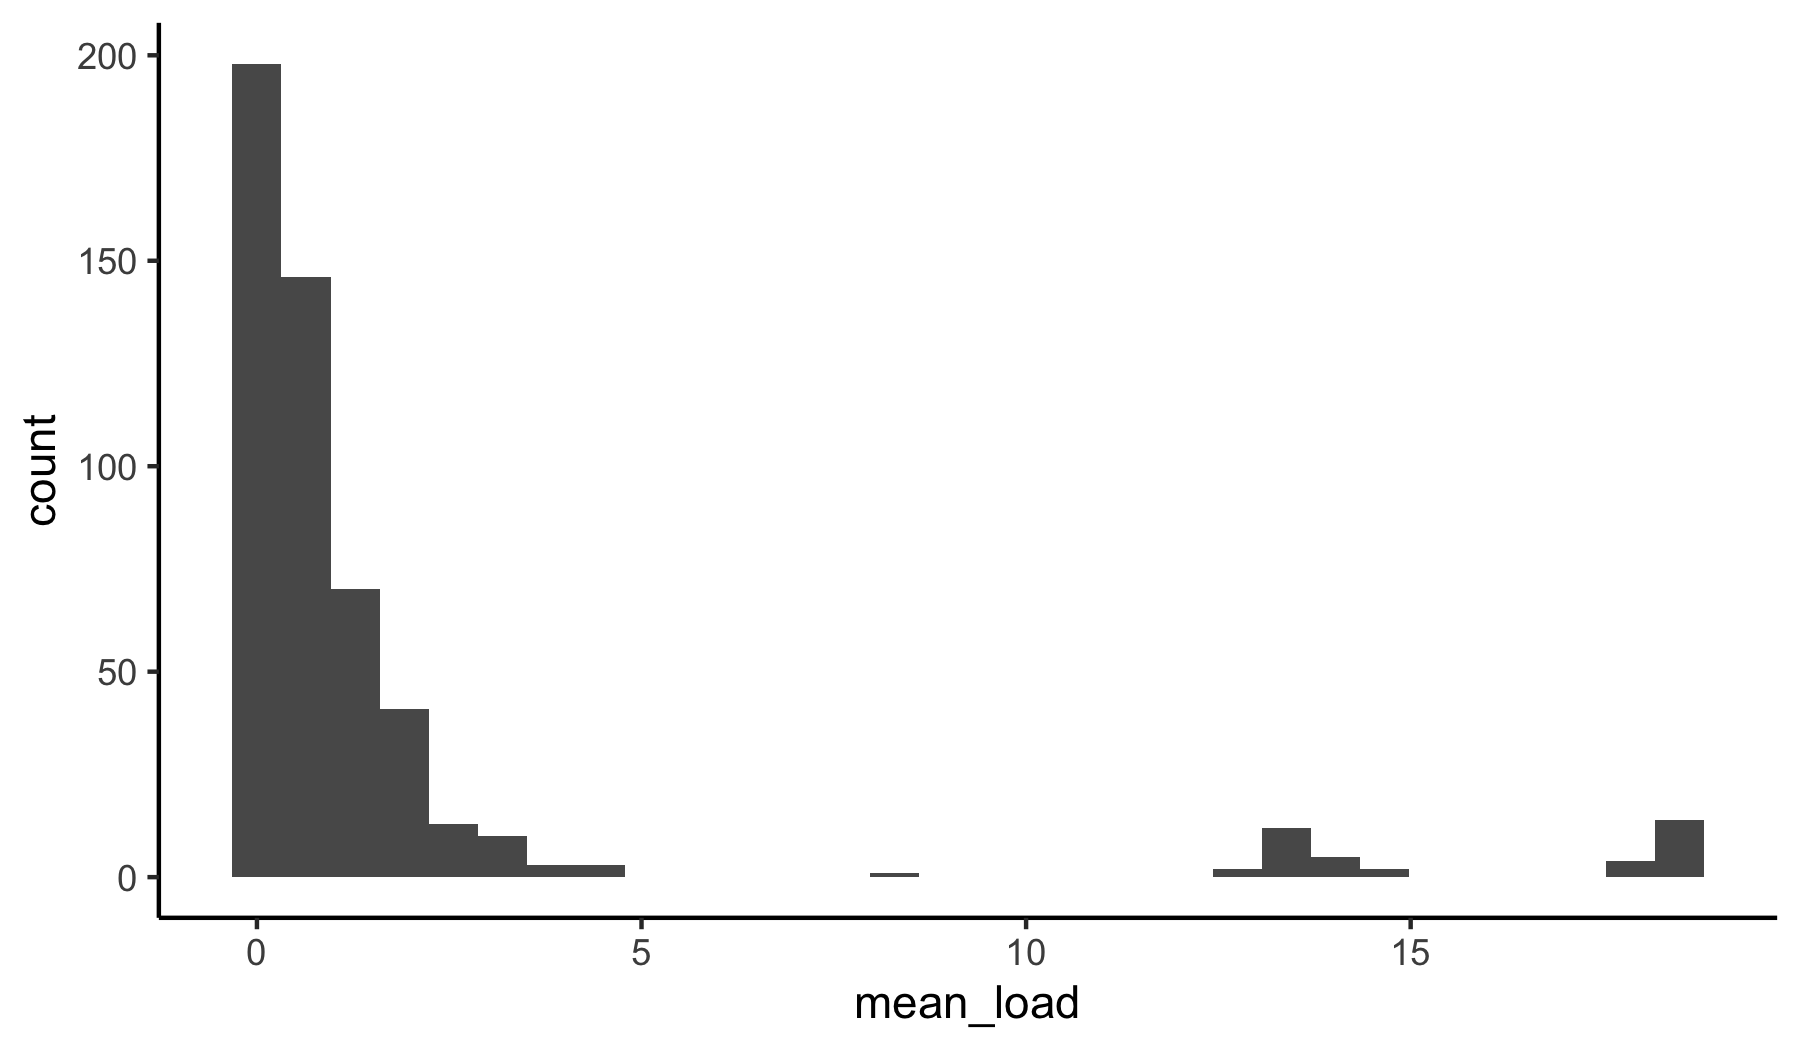

In [22]:
ggplot(benchmarks, aes(x = mean_load)) +
  geom_histogram() +
  theme_classic()

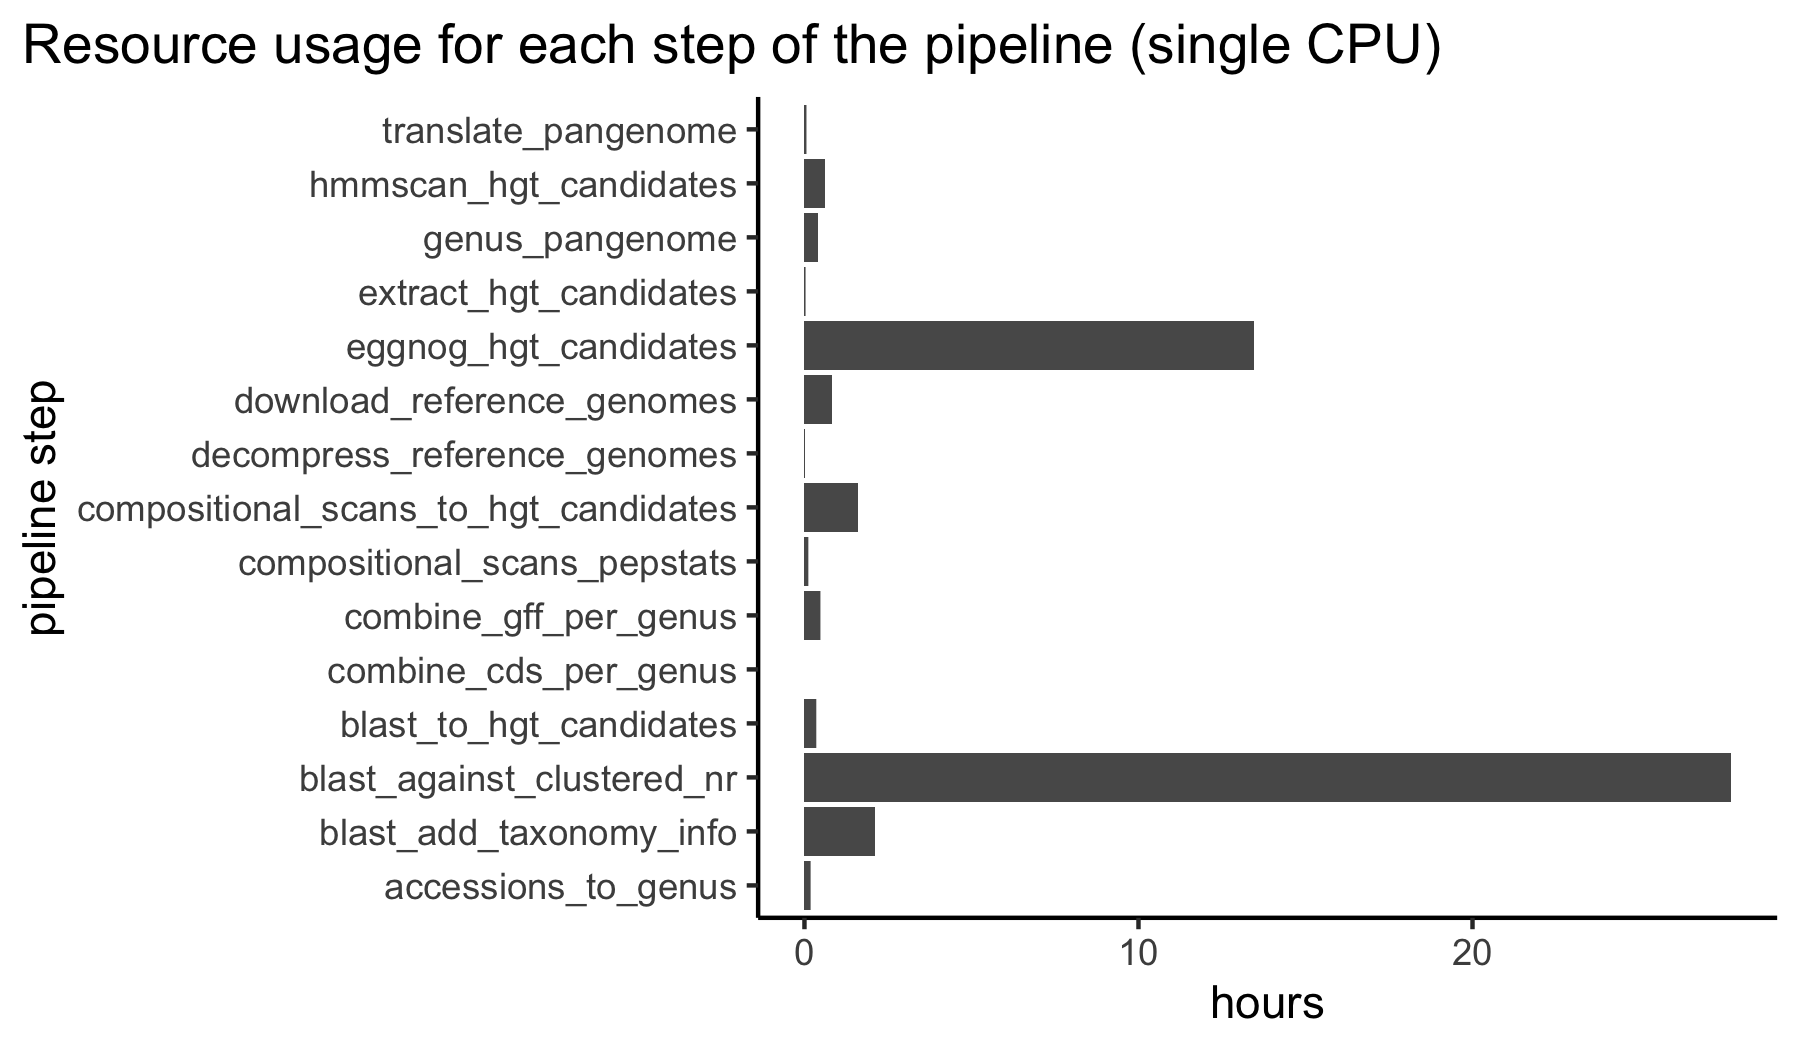

In [18]:
ggplot(benchmarks, aes(x = process, y = s/60/60)) +
  geom_col() +
  theme_classic() +
  coord_flip() +
  labs(y = "hours", x = "pipeline step", 
       title = "Resource usage for each step of the pipeline") +
  theme(plot.title.position = "plot")

In [15]:
metadata <- read_tsv("inputs/candidate_fungi_for_bio_test_data_set.tsv", show_col_types = F)

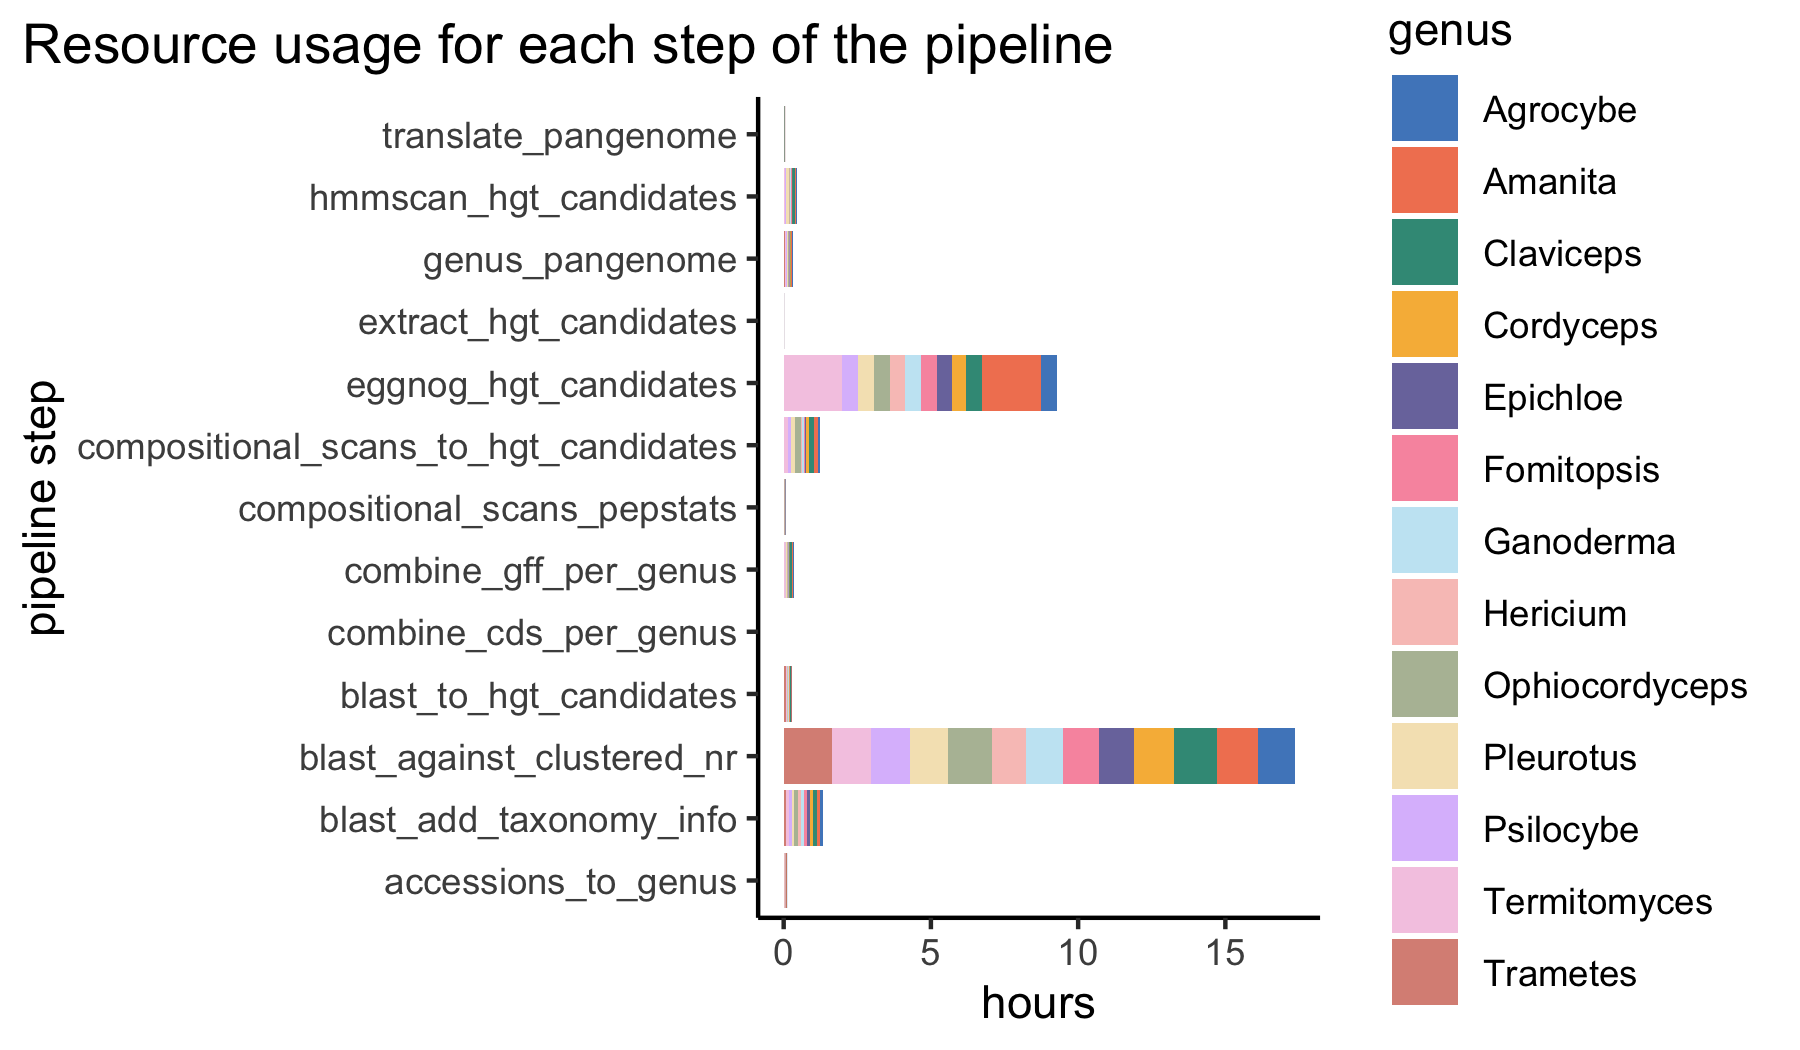

In [20]:
ggplot(benchmarks %>% 
         filter(!process %in% c("download_reference_genomes", "decompress_reference_genomes")) %>%
         filter(genus %in% metadata$genus),
       aes(x = process, y = s/60/60, fill = genus)) +
  geom_col() +
  theme_classic() +
  coord_flip() +
  labs(y = "hours", x = "pipeline step", 
       title = "Resource usage for each step of the pipeline") +
  theme(plot.title.position = "plot") +
  scale_fill_manual(values = c('#5088C5', '#F28360', '#3B9886', '#F7B846', 
                               '#7A77AB', '#F898AE', '#C6E7F4', '#F8C5C1',
                               '#B5BEA4', '#F5E4BE', '#DCBFFC', '#F5CBE4',
                               '#DA9085', '#B6C8D4'))

In [28]:
hours_per_genus <- benchmarks %>% 
  filter(!process %in% c("download_reference_genomes", "decompress_reference_genomes")) %>%
  filter(genus %in% metadata$genus) %>%
  group_by(genus) %>%
  summarise(sum_hours = sum(s/60/60))
mean(hours_per_genus$sum_hours)

[1] 2.37015

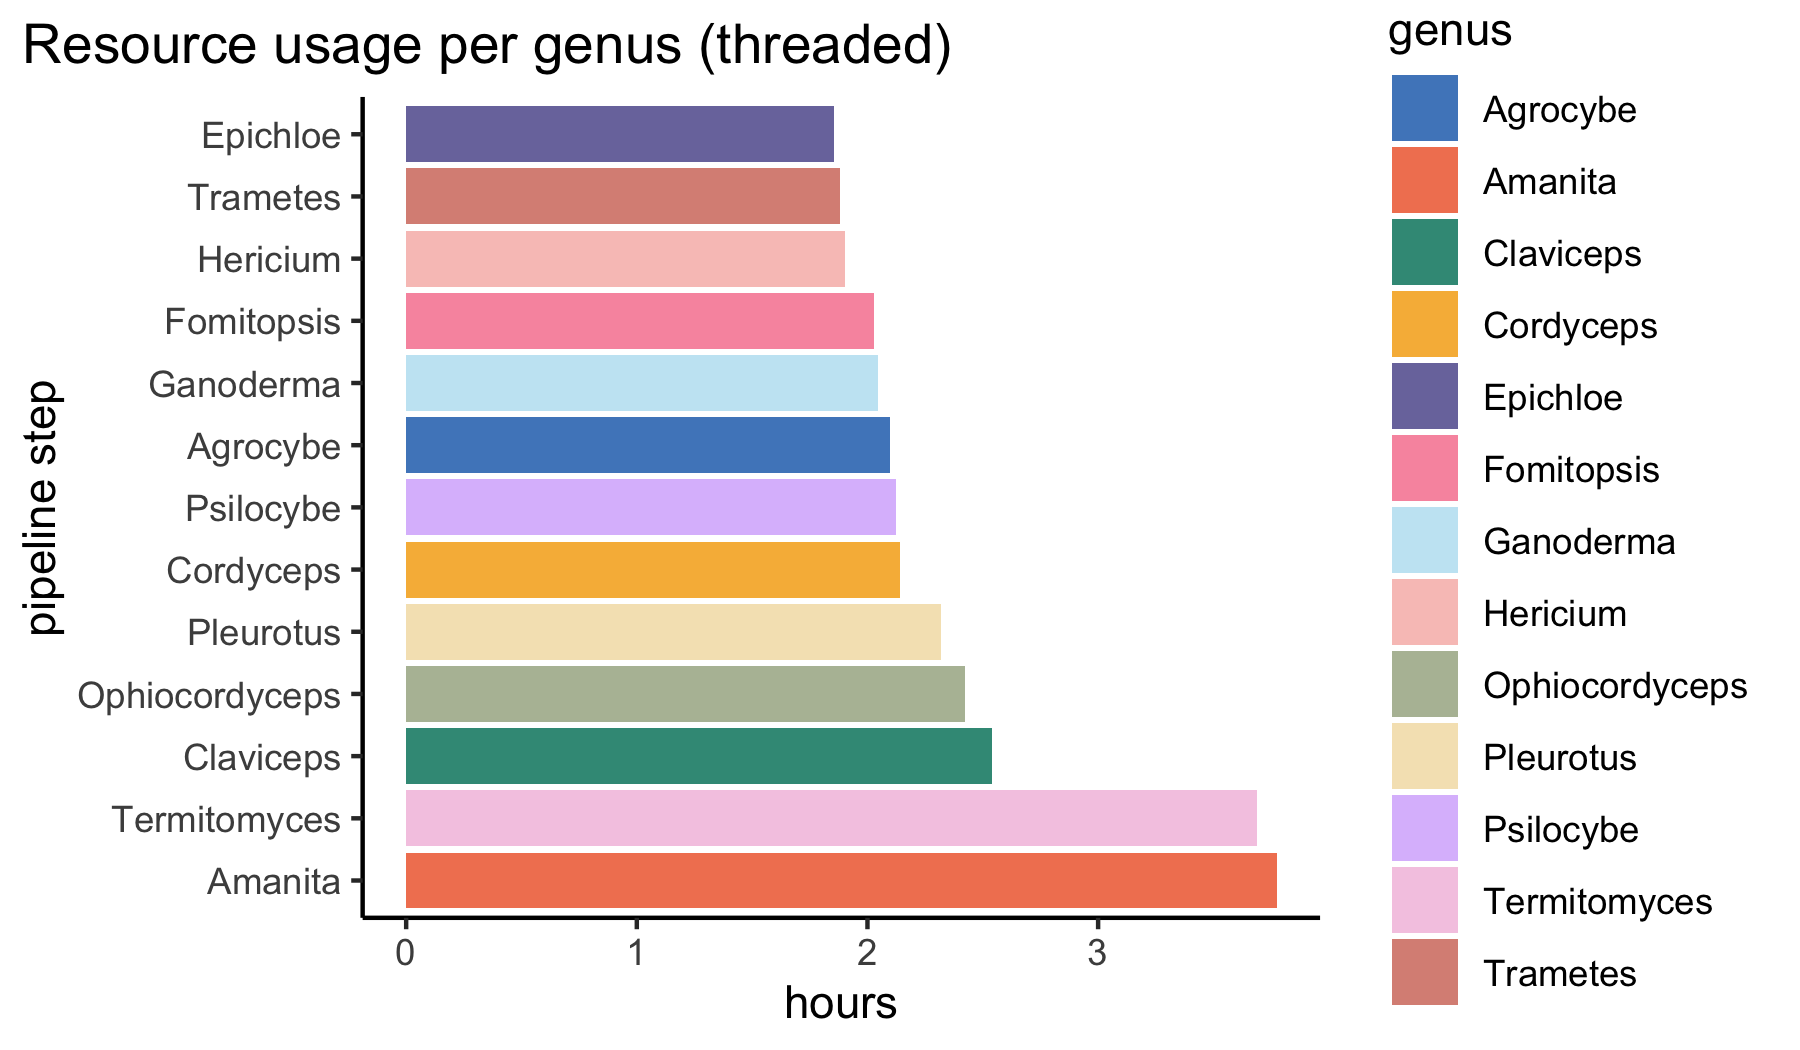

In [30]:
ggplot(hours_per_genus, aes(x = reorder(genus, -sum_hours), y = sum_hours, fill = genus)) +
  geom_col() +
  theme_classic() +
  coord_flip() +
  labs(y = "hours", x = "pipeline step", 
       title = "Resource usage per genus (threaded)") +
  theme(plot.title.position = "plot") +
  scale_fill_manual(values = c('#5088C5', '#F28360', '#3B9886', '#F7B846', 
                               '#7A77AB', '#F898AE', '#C6E7F4', '#F8C5C1',
                               '#B5BEA4', '#F5E4BE', '#DCBFFC', '#F5CBE4',
                               '#DA9085', '#B6C8D4'))

## report environment information

In [31]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.21.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.0 tidyr_1.2.1   dplyr_1.0.10  readr_2.1.3   purrr_1.0.1  

loaded via a namespace (and not attached):
 [1] pillar_1.8.1     compiler_4.2.1   base64enc_0.1-3  tools_4.2.1     
 [5] bit_4.0.5        digest_0.6.31    uuid_1.1-0       jsonlite_1.8.4  
 [9] evaluate_0.20    lifecycle_1.0.3  tibble_3.1.8     gtable_0.3.1    
[13] pkgconfig_2.0.3  rlang_1.0.6      IRdisplay_1.1    cli_3.6.0       
[17] DBI_1.1.3        parallel_4.2.1   IRkernel_1.3     fastmap_1.1.0   
[21] withr_2.5.0      repr_1.1.4       generics_0.1.3   vctrs_0.5.1     
[25] hms_1.1.